The below is the Solution to the 2nd Session on Friends Of Tracking Introduction to Tracking Data series.

In [1]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# set up initial path to data
DATADIR = 'D:/Users/Desktop/Friends of Tracking/Lesson 5/Metrica Data/data'
game_id = 2 # let's look at sample match 2

In [3]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

In [4]:
# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

Reading team: home
Reading team: away


In [5]:
# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

In [6]:
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

In [7]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving average')

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1dcf262bda0>)

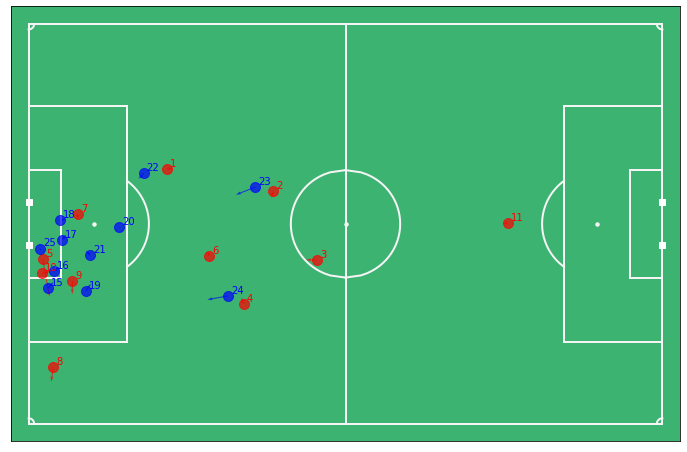

In [8]:
# plot a random frame, plotting the player velocities using quivers
mviz.plot_frame( tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities=True, annotate=True)

# Question 1: Estimate the top speed of each player

In [9]:
# Create a Physical summary dataframe for home players
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] )
home_summary = pd.DataFrame(index=home_players)

# Create a Physical summary dataframe for away players
away_players = np.unique( [ c.split('_')[1] for c in tracking_away.columns if c[:4] == 'Away' ] )
away_summary = pd.DataFrame(index=away_players)

Calculating Sustained sprints to find the Number of Sprints each player makes

In [10]:
# sustained sprints: how many sustained sprints per match did each player complete? Defined as maintaining a speed > 7 m/s for at least 1 second
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints

In [11]:
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in away_summary.index:
    column = 'Away_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_away[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
away_summary['# sprints'] = nsprints

In [12]:
home_summary

,# sprints
1,5
10,13
11,0
12,2
13,2
14,1
2,3
3,8
4,0
5,8


In [13]:
away_summary

,# sprints
15,3
16,4
17,4
18,11
19,8
20,1
21,3
22,8
23,10
24,9


There's a group of three players who made >=10 sprints.

It seems like a pretty good assumption that a player would have reached his/her top speed in making >=10 sprints

In [14]:
#Let's see the Relationship between top speeds and 70th percentile speeds of these players

print(tracking_home['Home_10_speed'].max()/tracking_home['Home_10_speed'].quantile(q=0.7))
print(tracking_away['Away_18_speed'].max()/tracking_away['Away_18_speed'].quantile(q=0.7))
print(tracking_away['Away_23_speed'].max()/tracking_away['Away_23_speed'].quantile(q=0.7))

5.0305849937056895
4.428677948788836
4.617069500842264


It seems a multiplying factor of ~4.5 would work quite well to estimate top speed for other players.

In [15]:
for i in home_summary.index:
    top_speed = max(round(tracking_home['Home_'+i+'_speed'].max(),2),round(tracking_home['Home_'+i+'_speed'].quantile(q=0.7)*4.5,2))
    print('Home_Player_'+i+":",top_speed)

Home_Player_1: 10.49
Home_Player_10: 10.29
Home_Player_11: 9.95
Home_Player_12: 10.43
Home_Player_13: 9.03
Home_Player_14: 9.81
Home_Player_2: 9.44
Home_Player_3: 10.25
Home_Player_4: 10.65
Home_Player_5: 12.21
Home_Player_6: 12.4
Home_Player_7: 11.39
Home_Player_8: 12.28
Home_Player_9: 9.25


In [16]:
for i in away_summary.index:
    top_speed = max(round(tracking_away['Away_'+i+'_speed'].max(),2),round(tracking_away['Away_'+i+'_speed'].quantile(q=0.7)*4.5,2))
    print('Away_Player_'+i+":",top_speed)

Away_Player_15: 11.42
Away_Player_16: 11.08
Away_Player_17: 9.66
Away_Player_18: 10.12
Away_Player_19: 11.29
Away_Player_20: 11.7
Away_Player_21: 9.98
Away_Player_22: 9.72
Away_Player_23: 8.93
Away_Player_24: 9.73
Away_Player_25: 10.69
Away_Player_26: 9.34


This is maybe not the best way to estimate top speeds and they certainly do not work for goalkeepers so the values should be taken with a pinch of salt.

I believe Laurie will have a better way of estimating these top speeds.

# Question 2: Measure player acceleration from the tracking data and estimate the maximum rate of acceleration for each player

In [17]:
home_speed_cols = [c for c in tracking_home.columns if 'speed' in c]
away_speed_cols = [c for c in tracking_away.columns if 'speed' in c]

In [18]:
#To calculate Accelerations

home_acc = tracking_home[home_speed_cols].diff()/0.04
away_acc = tracking_away[away_speed_cols].diff()/0.04

In [19]:
home_speed_cols = home_acc.columns
home_acc_cols = []
for i in home_speed_cols:
    i=i.replace('speed','acc')
    home_acc_cols.append(i)
    
away_speed_cols = away_acc.columns
away_acc_cols = []
for i in away_speed_cols:
    i=i.replace('speed','acc')
    away_acc_cols.append(i)

In [20]:
home_acc.columns = home_acc_cols
away_acc.columns = away_acc_cols

In [21]:
home_acc = home_acc.apply(lambda x:[y if abs(y)<=10 else 'NaN' for y in x])
away_acc = away_acc.apply(lambda x:[y if abs(y)<=10 else 'NaN' for y in x])

In [22]:
home_acc = home_acc.astype('float')
away_acc = away_acc.astype('float')

In [23]:
home_acc.max()

Home_1_acc     9.965972
Home_10_acc    9.976902
Home_11_acc    9.869373
Home_12_acc    9.697543
Home_13_acc    9.911306
Home_14_acc    9.792610
Home_2_acc     9.932294
Home_3_acc     9.980101
Home_4_acc     9.988945
Home_5_acc     9.995834
Home_6_acc     9.980079
Home_7_acc     9.995021
Home_8_acc     9.492847
Home_9_acc     9.935818
dtype: float64

In [24]:
away_acc.max()

Away_15_acc    9.941704
Away_16_acc    9.993423
Away_17_acc    9.763942
Away_18_acc    9.988715
Away_19_acc    9.996621
Away_20_acc    9.930703
Away_21_acc    8.562663
Away_22_acc    9.573369
Away_23_acc    9.970361
Away_24_acc    9.968750
Away_25_acc    9.906095
Away_26_acc    9.994877
dtype: float64

In [27]:
#Let's see the Relationship between top accelerations and 70th percentile accelerations of these players

print(home_acc['Home_10_acc'].max()/home_acc['Home_10_acc'].quantile(q=0.7))
print(away_acc['Away_18_acc'].max()/away_acc['Away_18_acc'].quantile(q=0.7))
print(away_acc['Away_23_acc'].max()/away_acc['Away_23_acc'].quantile(q=0.7))

35.15832351836984
32.78774182021461
37.83677956883307


A factor of ~35 seems good

In [30]:
for i in home_summary.index:
    top_acc = max(home_acc['Home_'+i+'_acc'].max(),home_acc['Home_'+i+'_acc'].quantile(q=0.7)*35)
    if top_acc<=10:
        print('Home_Player_'+i+":",top_acc)
    else:
        print('Home_Player_'+i+":",home_acc['Home_'+i+'_acc'].max())

for i in away_summary.index:
    top_acc = max(away_acc['Away_'+i+'_acc'].max(),away_acc['Away_'+i+'_acc'].quantile(q=0.7)*35)
    if top_acc<=10:
        print('Away_Player_'+i+":",top_acc)
    else:
        print('Away_Player_'+i+":",away_acc['Away_'+i+'_acc'].max())

Home_Player_1: 9.965971746239422
Home_Player_10: 9.976902234017592
Home_Player_11: 9.937347309169326
Home_Player_12: 9.813919773405138
Home_Player_13: 9.911305643672364
Home_Player_14: 9.792610150905423
Home_Player_2: 9.932294132097569
Home_Player_3: 9.980100550103987
Home_Player_4: 9.98894510787036
Home_Player_5: 9.995833626296612
Home_Player_6: 9.980079030163735
Home_Player_7: 9.995020740709814
Home_Player_8: 9.492847033172913
Home_Player_9: 9.935817911905293
Away_Player_15: 9.941704024321252
Away_Player_16: 9.99342334663299
Away_Player_17: 9.763941939060016
Away_Player_18: 9.988715209107813
Away_Player_19: 9.996621488829538
Away_Player_20: 9.930702973778516
Away_Player_21: 8.562662715212833
Away_Player_22: 9.57336940038328
Away_Player_23: 9.970361056840071
Away_Player_24: 9.968749809261473
Away_Player_25: 9.906095178624351
Away_Player_26: 9.994877105295725


I'm not quite sure the approach works well for estimation of Top Accelerations as the values are very simiar to one another.